# <font style="color:blue">Optimization Algorithms</font>

We know the theory behind a few optimizers (gradient descent, gradient descent with momentum, Rmsprop, and  Adam). Let's see how to use these optimizers in PyTorch.

`torch.optim` is a PyTorch package where various optimization algorithms are implemented. Get details of the package [here](https://pytorch.org/docs/stable/optim.html).

We will use the "**Fashion MNIST**" dataset to illustrate the convergence of different optimization algorithm.

We will use the same network which we have used in LeNet with batch norm notebook.


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [3]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

# <font style="color:blue">1. LeNet Architecture with BatchNorm</font>


In [4]:
class LeNetBN(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

# <font style="color:blue">2. Display the Network</font>

In [5]:
lenetBN_model = LeNetBN()
print(lenetBN_model)

LeNetBN(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# <font style="color:blue">3. Get Fashion MNIST Data</font>

In [6]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scale image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.2860) and divide by variance (0.3530).
        # This mean and variance is calculated on training data (verify yourself)
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

# <font style="color:blue">4. System Configuration</font>

In [7]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

# <font style="color:blue">5. Training Configuration</font>

In [8]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 50  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 500  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "./data"  # folder to save Fashion MNIST data (default: data)
    num_workers: int = 10  # number of concurrent processes using to prepare data
    device: str = 'cuda'  # device to use for training.
    


# <font style="color:blue">6. System Setup</font>

In [9]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# <font style="color:blue">7. Training</font>
We are familiar with the training pipeline used in PyTorch.

In [10]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

# <font style="color:blue">8. Validation</font>

In [11]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

# <font style="color:blue">9. Main</font>

In this section of code, we use the configuration parameters defined above and start the training. Here are the important actions being taken in the code below:

1. Set up system parameters like CPU/GPU, number of threads etc
1. Load the data using dataloaders
1. For each epoch, call train function, and for every test interval, call validation function. 
1. Set up variables to track loss and accuracy and start training.



In [12]:
def main(model, optimizer, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

# <font style="color:blue">10. Training: SGD (Gradient Descent)</font>

**Gradient descent update rule:**

$$
W_t = W_{t-1} -\alpha g_{t-1}
$$

where,

$$
W = \begin{bmatrix}
           w_{1} \\
           w_{2} \\
           \vdots \\
           w_{n}
         \end{bmatrix}
$$

and,


$$
g = \begin{bmatrix}
           \frac{\partial L}{\partial w_1} \\
           \frac{\partial L}{\partial w_2}  \\
           \vdots \\
           \frac{\partial L}{\partial w_n} 
         \end{bmatrix}
$$

**For stochastic gradient descent update, we use the following method in PyTorch:** 


```
torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```
- `params` (iterable) – iterable of parameters to optimize or dicts defining parameter groups. `model.parameters()` gives iterable model parameters. 

- `lr` (python:float) – learning rate

- `momentum` (python:float, optional) – momentum factor (default: 0)

- `weight_decay` (python:float, optional) – weight decay (L2 penalty) (default: 0)

- `dampening` (python:float, optional) – dampening for momentum (default: 0)

- `nesterov` (bool, optional) – enables Nesterov momentum (default: False)

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [13]:
model = LeNetBN()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate
)


model, train_loss_sgd, train_acc_sgd, test_loss_sgd, test_acc_sgd = main(model, optimizer)



0it [00:00, ?it/s]

26427392it [00:04, 5745536.79it/s]                              


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 68723.19it/s]                            
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


4423680it [00:01, 2789716.40it/s]                            
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


8192it [00:00, 25402.83it/s]            


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!
Train Epoch: 0 [16000/60000] Loss: 0.646716 Acc: 0.7812
Train Epoch: 0 [32000/60000] Loss: 0.478345 Acc: 0.7812
Train Epoch: 0 [48000/60000] Loss: 0.427159 Acc: 0.7500
Elapsed 7.35s, 7.35 s/epoch, 0.00 s/batch, ets 360.39s

Test set: Average loss: 0.4686, Accuracy: 8217/10000 (82%)

Train Epoch: 1 [16000/60000] Loss: 0.335557 Acc: 0.8750
Train Epoch: 1 [32000/60000] Loss: 0.403419 Acc: 0.9062
Train Epoch: 1 [48000/60000] Loss: 0.393084 Acc: 0.8750
Elapsed 15.63s, 7.81 s/epoch, 0.00 s/batch, ets 375.03s

Test set: Average loss: 0.3958, Accuracy: 8581/10000 (86%)

Train Epoch: 2 [16000/60000] Loss: 0.504199 Acc: 0.8438
Train Epoch: 2 [32000/60000] Loss: 0.701099 Acc: 0.7500
Train Epoch: 2 [48000/60000] Loss: 0.433771 Acc: 0.7812
Elapsed 24.03s, 8.01 s/epoch, 0.00 s/batch, ets 376.51s

Test set: Average loss: 0.3553, Accuracy: 8705/10000 (87%)

Train Epoch: 3 [16000/60000] Loss: 0.2

Train Epoch: 28 [32000/60000] Loss: 0.031947 Acc: 1.0000
Train Epoch: 28 [48000/60000] Loss: 0.059286 Acc: 1.0000
Elapsed 239.80s, 8.27 s/epoch, 0.00 s/batch, ets 173.65s

Test set: Average loss: 0.2800, Accuracy: 9044/10000 (90%)

Train Epoch: 29 [16000/60000] Loss: 0.213840 Acc: 0.8750
Train Epoch: 29 [32000/60000] Loss: 0.102900 Acc: 0.9688
Train Epoch: 29 [48000/60000] Loss: 0.083884 Acc: 0.9688
Elapsed 247.83s, 8.26 s/epoch, 0.00 s/batch, ets 165.22s

Test set: Average loss: 0.2947, Accuracy: 9008/10000 (90%)

Train Epoch: 30 [16000/60000] Loss: 0.187557 Acc: 0.9375
Train Epoch: 30 [32000/60000] Loss: 0.082611 Acc: 1.0000
Train Epoch: 30 [48000/60000] Loss: 0.227995 Acc: 0.9375
Elapsed 256.24s, 8.27 s/epoch, 0.00 s/batch, ets 157.05s

Test set: Average loss: 0.2910, Accuracy: 9018/10000 (90%)

Train Epoch: 31 [16000/60000] Loss: 0.057514 Acc: 1.0000
Train Epoch: 31 [32000/60000] Loss: 0.073438 Acc: 0.9688
Train Epoch: 31 [48000/60000] Loss: 0.138749 Acc: 0.9375
Elapsed 264.57s, 8.

# <font style="color:blue">11. Training: SGD with Momentum</font>

**Gradient descent with momentun update rule:**

$$
\begin{align}
v_t &= \beta v_{t-1} + (1 - \beta) g_{t-1} \\
\\
W_t &= W_{t-1} - \alpha v_t \\
\end{align}
$$


**In PyTorch, we use `torch.optim.SGD` with non-zero momentum value.**

In the following training, we will use $\beta = 0.9$. Here $\beta$ is momentum.


In [14]:
model = LeNetBN()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate,
    # to use momentum, changed default value 0 to 0.9
    momentum = 0.9
)


model, train_loss_sgd_momentum, train_acc_sgd_momentum, test_loss_sgd_momentum, test_acc_sgd_momentum = main(
    model, 
    optimizer)



Train Epoch: 0 [16000/60000] Loss: 0.494858 Acc: 0.8125
Train Epoch: 0 [32000/60000] Loss: 0.261072 Acc: 0.8750
Train Epoch: 0 [48000/60000] Loss: 0.334661 Acc: 0.8750
Elapsed 8.39s, 8.39 s/epoch, 0.00 s/batch, ets 410.88s

Test set: Average loss: 0.3735, Accuracy: 8643/10000 (86%)

Train Epoch: 1 [16000/60000] Loss: 0.220575 Acc: 0.9688
Train Epoch: 1 [32000/60000] Loss: 0.365529 Acc: 0.8750
Train Epoch: 1 [48000/60000] Loss: 0.221897 Acc: 0.9375
Elapsed 17.52s, 8.76 s/epoch, 0.00 s/batch, ets 420.42s

Test set: Average loss: 0.3202, Accuracy: 8825/10000 (88%)

Train Epoch: 2 [16000/60000] Loss: 0.289806 Acc: 0.8438
Train Epoch: 2 [32000/60000] Loss: 0.688733 Acc: 0.7812
Train Epoch: 2 [48000/60000] Loss: 0.317980 Acc: 0.8750
Elapsed 26.56s, 8.85 s/epoch, 0.00 s/batch, ets 416.06s

Test set: Average loss: 0.3095, Accuracy: 8883/10000 (89%)

Train Epoch: 3 [16000/60000] Loss: 0.134292 Acc: 0.9688
Train Epoch: 3 [32000/60000] Loss: 0.271700 Acc: 0.9062
Train Epoch: 3 [48000/60000] Loss:

Elapsed 262.33s, 9.05 s/epoch, 0.00 s/batch, ets 189.97s

Test set: Average loss: 0.3997, Accuracy: 9055/10000 (91%)

Train Epoch: 29 [16000/60000] Loss: 0.056993 Acc: 0.9688
Train Epoch: 29 [32000/60000] Loss: 0.050627 Acc: 1.0000
Train Epoch: 29 [48000/60000] Loss: 0.011540 Acc: 1.0000
Elapsed 271.42s, 9.05 s/epoch, 0.00 s/batch, ets 180.94s

Test set: Average loss: 0.4148, Accuracy: 9013/10000 (90%)

Train Epoch: 30 [16000/60000] Loss: 0.039378 Acc: 1.0000
Train Epoch: 30 [32000/60000] Loss: 0.137639 Acc: 0.9688
Train Epoch: 30 [48000/60000] Loss: 0.155474 Acc: 0.9375
Elapsed 280.43s, 9.05 s/epoch, 0.00 s/batch, ets 171.87s

Test set: Average loss: 0.4077, Accuracy: 9044/10000 (90%)

Train Epoch: 31 [16000/60000] Loss: 0.065780 Acc: 0.9688
Train Epoch: 31 [32000/60000] Loss: 0.024158 Acc: 1.0000
Train Epoch: 31 [48000/60000] Loss: 0.340769 Acc: 0.9375
Elapsed 289.52s, 9.05 s/epoch, 0.00 s/batch, ets 162.85s

Test set: Average loss: 0.4506, Accuracy: 9046/10000 (90%)

Train Epoch: 32

# <font style="color:blue">12. Training: RMSProp</font>

**RMSProp update rule:**

$$
\begin{align}
s_t &= \beta s_{t-1} + (1 - \beta) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {g_{t-1}}{\sqrt s_t + \epsilon} \\
\end{align}
$$

**For RMSProp weight update, we use the following method in PyTorch:** 

```
torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
```
- `params` (iterable) – iterable of parameters to optimize or dicts defining parameter groups

- `lr` (python:float, optional) – learning rate (default: 1e-2). $\alpha$ is learning rate in the `RMSProp` update rule.

- `momentum` (python:float, optional) – momentum factor (default: 0)

- `alpha` (python:float, optional) – smoothing constant (default: 0.99). $\beta$ is smothing constant in the `RMSProp` update rule.

- `eps` (python:float, optional) – term added to the denominator to improve numerical stability (default: 1e-8). This $\epsilon$ is the `RMSProp` update rule.

- `centered` (bool, optional) – if True, compute the centered RMSProp, the gradient is normalized by an estimation of its variance

- `weight_decay` (python:float, optional) – weight decay (L2 penalty) (default: 0)



Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop).

In [15]:
model = LeNetBN()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.RMSprop(
    model.parameters(),
)


model, train_loss_rms_prop, train_acc_rms_prop, test_loss_rms_prop, test_acc_rms_prop = main(model, optimizer)



Train Epoch: 0 [16000/60000] Loss: 0.749469 Acc: 0.7500
Train Epoch: 0 [32000/60000] Loss: 0.419833 Acc: 0.8750
Train Epoch: 0 [48000/60000] Loss: 0.383243 Acc: 0.9062
Elapsed 9.66s, 9.66 s/epoch, 0.01 s/batch, ets 473.56s

Test set: Average loss: 0.4981, Accuracy: 8225/10000 (82%)

Train Epoch: 1 [16000/60000] Loss: 0.360825 Acc: 0.8750
Train Epoch: 1 [32000/60000] Loss: 0.587804 Acc: 0.8438
Train Epoch: 1 [48000/60000] Loss: 0.259435 Acc: 0.8750
Elapsed 19.99s, 10.00 s/epoch, 0.01 s/batch, ets 479.81s

Test set: Average loss: 0.3870, Accuracy: 8656/10000 (87%)

Train Epoch: 2 [16000/60000] Loss: 0.383624 Acc: 0.8125
Train Epoch: 2 [32000/60000] Loss: 0.642671 Acc: 0.7500
Train Epoch: 2 [48000/60000] Loss: 0.435198 Acc: 0.8750
Elapsed 30.37s, 10.12 s/epoch, 0.01 s/batch, ets 475.73s

Test set: Average loss: 0.3818, Accuracy: 8664/10000 (87%)

Train Epoch: 3 [16000/60000] Loss: 0.302895 Acc: 0.8750
Train Epoch: 3 [32000/60000] Loss: 0.389457 Acc: 0.8125
Train Epoch: 3 [48000/60000] Los

Train Epoch: 28 [48000/60000] Loss: 0.152503 Acc: 0.9062
Elapsed 302.10s, 10.42 s/epoch, 0.01 s/batch, ets 218.76s

Test set: Average loss: 0.3978, Accuracy: 8705/10000 (87%)

Train Epoch: 29 [16000/60000] Loss: 0.291183 Acc: 0.8125
Train Epoch: 29 [32000/60000] Loss: 0.231686 Acc: 0.8750
Train Epoch: 29 [48000/60000] Loss: 0.206817 Acc: 0.9375
Elapsed 312.38s, 10.41 s/epoch, 0.01 s/batch, ets 208.25s

Test set: Average loss: 0.3786, Accuracy: 8676/10000 (87%)

Train Epoch: 30 [16000/60000] Loss: 0.413487 Acc: 0.8750
Train Epoch: 30 [32000/60000] Loss: 0.186355 Acc: 0.9688
Train Epoch: 30 [48000/60000] Loss: 0.499157 Acc: 0.8438
Elapsed 322.82s, 10.41 s/epoch, 0.01 s/batch, ets 197.86s

Test set: Average loss: 0.4732, Accuracy: 8317/10000 (83%)

Train Epoch: 31 [16000/60000] Loss: 0.275772 Acc: 0.8750
Train Epoch: 31 [32000/60000] Loss: 0.266252 Acc: 0.9375
Train Epoch: 31 [48000/60000] Loss: 0.649661 Acc: 0.8438
Elapsed 333.22s, 10.41 s/epoch, 0.01 s/batch, ets 187.44s

Test set: Aver

# <font style="color:blue">13. Training: Adam (Momentum + RMSProp)</font>

**Adam update rule:**
$$
\begin{align}
v_t &= \beta_1 v_{t-1} + (1 - \beta_1) g_{t-1} \\
\\
s_t &= \beta_2 s_{t-1} + (1 - \beta_2) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {v_{t}}{\sqrt s_t + \epsilon} \\
\end{align}
$$

**For Adam weight update, we use the following method in PyTorch:**

```
torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
```
- `params` (iterable) – iterable of parameters to optimize or dicts defining parameter groups

- `lr` (python:float, optional) – learning rate (default: `1e-3`). $\alpha$ is learning rate in Adam update rule.

- `betas` (Tuple[python:float, python:float], optional) – coefficients used for computing running averages of gradient and its square (default: `(0.9, 0.999)`). In Adam update rule, first value of tuple is $\beta_1$ and second value is $\beta_2$

- `weight_decay` (python:float, optional) – weight decay (L2 penalty) (default: `0`)

- `amsgrad` (boolean, optional) – whether to use the AMSGrad variant of this algorithm from the paper On the [Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ) (default: False)




Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [16]:
model = LeNetBN()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.Adam(
    model.parameters(),
)


model, train_loss_adam, train_acc_adam, test_loss_adam, test_acc_adam = main(model, optimizer)



Train Epoch: 0 [16000/60000] Loss: 0.496149 Acc: 0.8438
Train Epoch: 0 [32000/60000] Loss: 0.229780 Acc: 0.9062
Train Epoch: 0 [48000/60000] Loss: 0.314782 Acc: 0.8750
Elapsed 11.24s, 11.24 s/epoch, 0.01 s/batch, ets 550.74s

Test set: Average loss: 0.3626, Accuracy: 8703/10000 (87%)

Train Epoch: 1 [16000/60000] Loss: 0.287124 Acc: 0.9375
Train Epoch: 1 [32000/60000] Loss: 0.429240 Acc: 0.8750
Train Epoch: 1 [48000/60000] Loss: 0.256273 Acc: 0.8750
Elapsed 23.22s, 11.61 s/epoch, 0.01 s/batch, ets 557.21s

Test set: Average loss: 0.3306, Accuracy: 8788/10000 (88%)

Train Epoch: 2 [16000/60000] Loss: 0.292037 Acc: 0.9062
Train Epoch: 2 [32000/60000] Loss: 0.692854 Acc: 0.7188
Train Epoch: 2 [48000/60000] Loss: 0.408861 Acc: 0.9062
Elapsed 35.02s, 11.67 s/epoch, 0.01 s/batch, ets 548.68s

Test set: Average loss: 0.3073, Accuracy: 8877/10000 (89%)

Train Epoch: 3 [16000/60000] Loss: 0.205590 Acc: 0.9688
Train Epoch: 3 [32000/60000] Loss: 0.225861 Acc: 0.9062
Train Epoch: 3 [48000/60000] L

Train Epoch: 28 [48000/60000] Loss: 0.008104 Acc: 1.0000
Elapsed 345.77s, 11.92 s/epoch, 0.01 s/batch, ets 250.38s

Test set: Average loss: 0.4595, Accuracy: 8952/10000 (90%)

Train Epoch: 29 [16000/60000] Loss: 0.095287 Acc: 0.9688
Train Epoch: 29 [32000/60000] Loss: 0.078285 Acc: 0.9688
Train Epoch: 29 [48000/60000] Loss: 0.010336 Acc: 1.0000
Elapsed 357.73s, 11.92 s/epoch, 0.01 s/batch, ets 238.49s

Test set: Average loss: 0.4738, Accuracy: 8992/10000 (90%)

Train Epoch: 30 [16000/60000] Loss: 0.015752 Acc: 1.0000
Train Epoch: 30 [32000/60000] Loss: 0.141109 Acc: 0.9375
Train Epoch: 30 [48000/60000] Loss: 0.191791 Acc: 0.9375
Elapsed 369.78s, 11.93 s/epoch, 0.01 s/batch, ets 226.64s

Test set: Average loss: 0.4872, Accuracy: 8980/10000 (90%)

Train Epoch: 31 [16000/60000] Loss: 0.054056 Acc: 0.9688
Train Epoch: 31 [32000/60000] Loss: 0.048216 Acc: 0.9688
Train Epoch: 31 [48000/60000] Loss: 0.051049 Acc: 0.9688
Elapsed 381.40s, 11.92 s/epoch, 0.01 s/batch, ets 214.54s

Test set: Aver

# <font style="color:blue">14. Loss Plot</font>

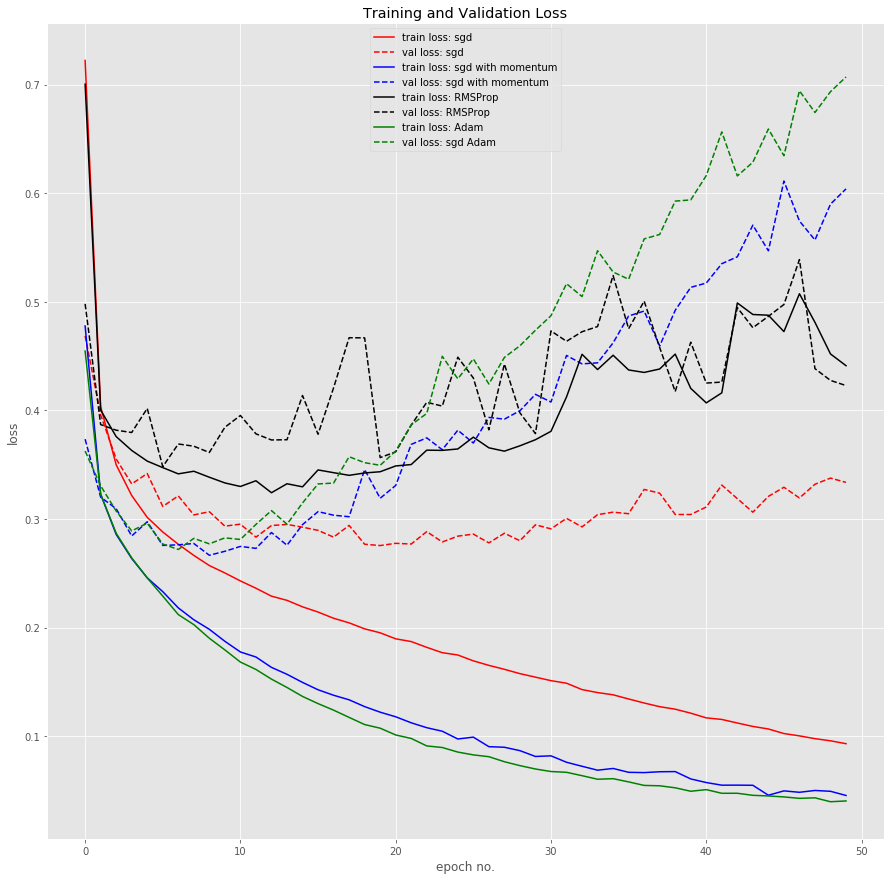

In [19]:
# Plot loss
plt.rcParams["figure.figsize"] = (15, 15)
x = range(len(train_loss_sgd))

plt.figure
plt.plot(x, train_loss_sgd, 'r', label="train loss: sgd")
plt.plot(x, test_loss_sgd, '--r', label="val loss: sgd")

plt.plot(x, train_loss_sgd_momentum, 'b', label="train loss: sgd with momentum")
plt.plot(x, test_loss_sgd_momentum, '--b', label="val loss: sgd with momentum")

plt.plot(x, train_loss_rms_prop, 'k', label="train loss: RMSProp")
plt.plot(x, test_loss_rms_prop, '--k', label="val loss: RMSProp")

plt.plot(x, train_loss_adam, 'g', label="train loss: Adam")
plt.plot(x, test_loss_adam, '--g', label="val loss: sgd Adam")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper center')
plt.title('Training and Validation Loss')
plt.show()

# <font style="color:blue">15. Accuracy Plot</font>

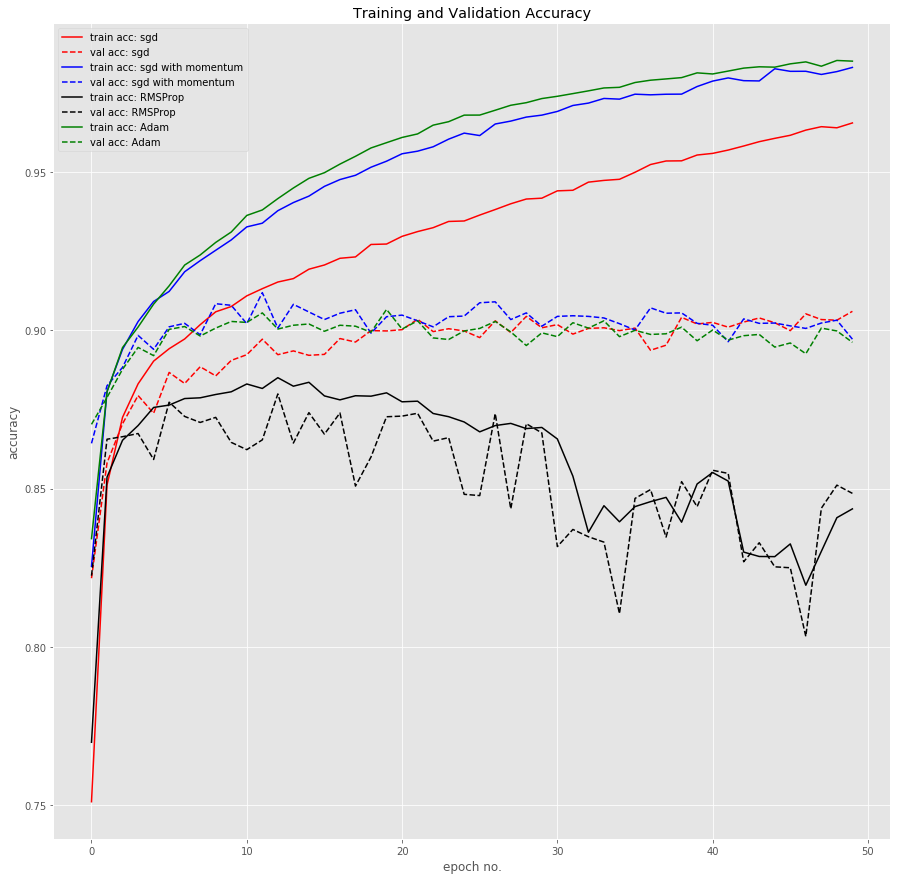

In [20]:
# Plot loss
plt.rcParams["figure.figsize"] = (15, 15)
x = range(len(train_loss_sgd))

plt.figure
plt.plot(x, train_acc_sgd, 'r', label="train acc: sgd")
plt.plot(x, test_acc_sgd, '--r', label="val acc: sgd")

plt.plot(x, train_acc_sgd_momentum, 'b', label="train acc: sgd with momentum")
plt.plot(x, test_acc_sgd_momentum, '--b', label="val acc: sgd with momentum")

plt.plot(x, train_acc_rms_prop, 'k', label="train acc: RMSProp")
plt.plot(x, test_acc_rms_prop, '--k', label="val acc: RMSProp")

plt.plot(x, train_acc_adam, 'g', label="train acc: Adam")
plt.plot(x, test_acc_adam, '--g', label="val acc: Adam")

plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.show()